In [1]:
import numpy as np
import pandas as pd
import os
from pathlib import Path

from numpy import arange
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

print(os.path.abspath("."))

# Specify Country:
country = ['Angola','Kenya','Ethiopia','Malawi','Namibia','Tunisia','Morocco','Rwanda','Uganda','Zambia']

C:\Users\USER\Documents\HKUST\MSBD 5001 - Foundations of Data Analytics\Group Project


#### Load & Preprocessing:

In [2]:
def get_yield_data() -> pd.DataFrame:
    yieldPath = Path(str(Path(os.getcwd()).parent.absolute()) + '/Group Project/Data/Yields/all_country_crop_yield_tons_per_hectare.csv')
    df = pd.read_csv(yieldPath)
    #df = df[df['Country Name'].isin(country)]
    df = df.melt(id_vars=["Country Name"], # narrow format 
                var_name="Year",   # rename
              value_name="Yield")  # rename
    df['Year'] = df['Year'].astype(int)
    return df

dfYieldLabel = get_yield_data()
#dfYieldLabel

# Expand this to include combine function below....
def get_VI_data() -> pd.DataFrame:
    trainPath = Path(str(Path(os.getcwd()).parent.absolute()) + '/Group Project/Data/NDVI/Country_EVI_NDVI.csv')
    df = pd.read_csv(trainPath)
    #df = df[df['Country Name'].isin(country)]
    df['Year'] = pd.DatetimeIndex(df['Date']).year.astype(int)
    df = df.groupby(['Country Name', 'Year'], as_index=False).mean() # avg by year
    return df

dfTrainData = get_VI_data()
#dfTrainData

#### Test, Train split:

In [5]:
predictCountry = 'Ethiopia'
predictYears = [2019, 2020, 2021]

def combine_train_test() -> pd.DataFrame:
    df = pd.merge(dfTrainData, dfYieldLabel,  how='left', left_on=['Country Name','Year'], right_on = ['Country Name','Year'])
    df = df[(df['Country Name'] == predictCountry)]
    return df

yearly_df = combine_train_test()
yearly_df

trainData = yearly_df.drop('Country Name', 1).dropna().values

X, y = trainData[:, :-1], trainData[:, -1]
#trainData

predData = yearly_df[yearly_df.Year.isin(predictYears)].drop(['Country Name', 'Yield'], 1).to_numpy()
#predData

#### Ridge Regression Model:

In [6]:
alphas = 10**np.linspace(10,-2,100)*0.5
#alphas

ridge = Ridge(normalize = True)
coefs = []

for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
    
#np.shape(coefs)

Text(0, 0.5, 'weights')

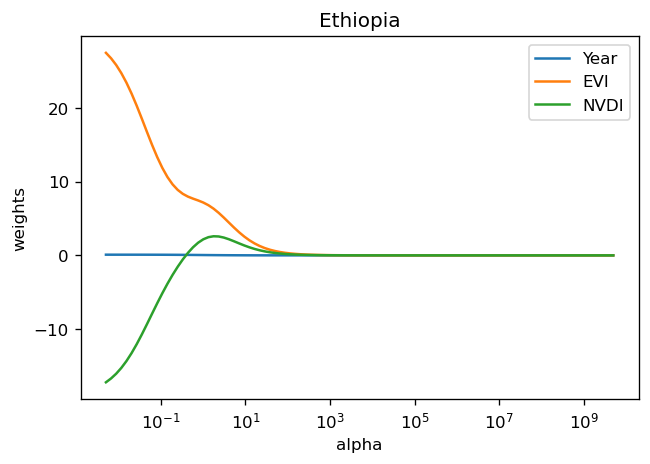

In [7]:
plt.figure(figsize=(6,4), dpi=120)
ax = plt.gca()
plt.title(predictCountry)
ax.plot(alphas, coefs)
ax.legend(['Year', 'EVI','NVDI'])
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

# expect the coefficient estimates to be much smaller, in terms of  l2  norm, 
# when a large value of alpha is used, as compared to when a small value of alpha is used.

In [8]:
#ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_absolute_percentage_error', normalize = True)
ridgecv.fit(X, y)
ridgecv.alpha_

0.10772173450159389

In [9]:
ridgeFinal = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridgeFinal.fit(X, y)
#mean_squared_error(y, ridge4.predict(X))

ridgeFinal

Ridge(alpha=0.10772173450159389, normalize=True)

In [10]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) #* 100

mean_absolute_percentage_error(y, ridgeFinal.predict(X))

0.06280436743690375

In [11]:
np.sqrt(mean_squared_error(y, ridgeFinal.predict(X)))

0.1304708253275411

In [12]:
# make a prediction
yhat = ridgeFinal.predict(predData)
yhat

array([2.6361012 , 2.74837884, 2.76229482])